<a href="https://colab.research.google.com/github/tomasonjo/blogs/blob/master/llm/ms_graphrag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet langchain-community langchain-experimental langchain-openai neo4j graphdatascience tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.7/202.7 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.5/293.5 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 975.5/975.5 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.4/337.4 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.5/127.5 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.3/328.3 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [2]:
import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass.getpass()

··········


In [3]:
from langchain_community.graphs import Neo4jGraph

os.environ["NEO4J_URI"] = "bolt://54.172.70.190:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "magnesium-cement-wafers"

graph = Neo4jGraph(refresh_schema=False)

In [41]:
import pandas as pd
import tiktoken


def num_tokens_from_string(string: str, model: str = "gpt-4o") -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.encoding_for_model(model)
    num_tokens = len(encoding.encode(string))
    return num_tokens


news = pd.read_csv(
    "https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/news_articles.csv"
)
news["tokens"] = [
    num_tokens_from_string(f"{row['title']} {row['text']}")
    for i, row in news.iterrows()
]
news.head()

,title,date,text,tokens
0,Chevron: Best Of Breed,2031-04-06T01:36:32.000000000+00:00,JHVEPhoto Like many companies in the O&G secto...,78
1,FirstEnergy (NYSE:FE) Posts Earnings Results,2030-04-29T06:55:28.000000000+00:00,FirstEnergy (NYSE:FE – Get Rating) posted its ...,130
2,Dáil almost suspended after Sinn Féin TD put p...,2023-06-15T14:32:11.000000000+00:00,The Dáil was almost suspended on Thursday afte...,631
3,Epic’s latest tool can animate hyperrealistic ...,2023-06-15T14:00:00.000000000+00:00,"Today, Epic is releasing a new tool designed t...",528
4,"EU to Ban Huawei, ZTE from Internal Commission...",2023-06-15T13:50:00.000000000+00:00,The European Commission is planning to ban equ...,281


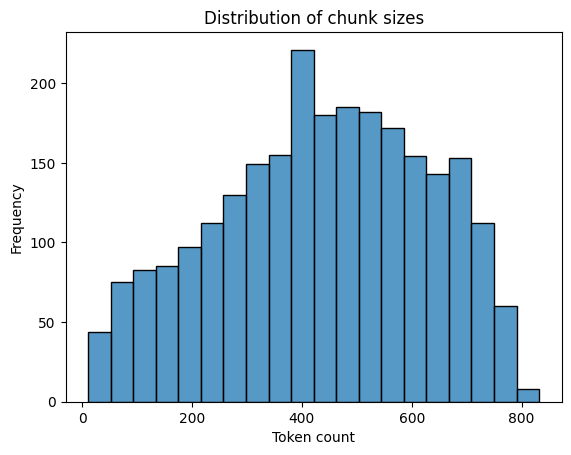

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.histplot(news["tokens"], kde=False)
plt.title('Distribution of chunk sizes')
plt.xlabel('Token count')
plt.ylabel('Frequency')
plt.show()

# Entity extraction

In [7]:
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

llm_transformer = LLMGraphTransformer(
    llm=llm,
    node_properties=["description"],
    relationship_properties=["description"]
)

In [8]:
from typing import List
from langchain_community.graphs.graph_document import GraphDocument
from langchain_core.documents import Document

def process_text(text: str) -> List[GraphDocument]:
    doc = Document(page_content=text)
    return llm_transformer.convert_to_graph_documents([doc])

In [9]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

MAX_WORKERS = 10
NUM_ARTICLES = 1000
graph_documents = []

with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    # Submitting all tasks and creating a list of future objects
    futures = [
        executor.submit(process_text, f"{row['title']} {row['text']}")
        for i, row in news.head(NUM_ARTICLES).iterrows()
    ]

    for future in tqdm(
        as_completed(futures), total=len(futures), desc="Processing documents"
    ):
        graph_document = future.result()
        graph_documents.extend(graph_document)

graph.add_graph_documents(
    graph_documents,
    baseEntityLabel=True,
    include_source=True
)

Processing documents: 100%|██████████| 1000/1000 [14:13<00:00,  1.17it/s]


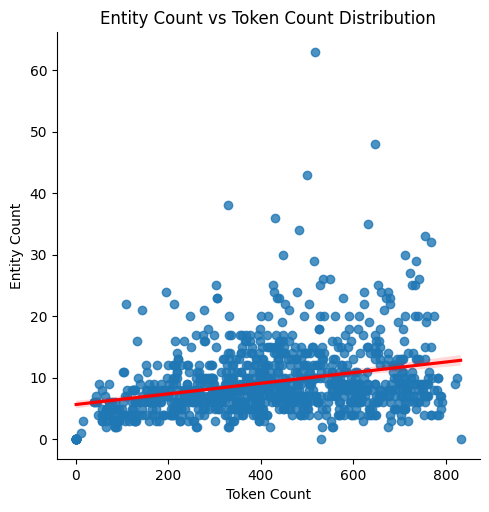

In [10]:
entity_dist = graph.query(
    """
MATCH (d:Document)
RETURN d.text AS text,
       count {(d)-[:MENTIONS]->()} AS entity_count
"""
)
entity_dist_df = pd.DataFrame.from_records(entity_dist)
entity_dist_df["token_count"] = [
    num_tokens_from_string(str(el)) for el in entity_dist_df["text"]
]
# Scatter plot with regression line
sns.lmplot(
    x="token_count", y="entity_count", data=entity_dist_df, line_kws={"color": "red"}
)
plt.title("Entity Count vs Token Count Distribution")
plt.xlabel("Token Count")
plt.ylabel("Entity Count")
plt.show()


In [12]:
graph.query("""
MATCH (n:`__Entity__`)
RETURN "node" AS type,
       count(*) AS total_count,
       count(n.description) AS non_null_descriptions
UNION ALL
MATCH (n)-[r:!MENTIONS]->()
RETURN "relationship" AS type,
       count(*) AS total_count,
       count(r.description) AS non_null_descriptions
""")

[{'type': 'node', 'total_count': 6830, 'non_null_descriptions': 2666},
 {'type': 'relationship', 'total_count': 8155, 'non_null_descriptions': 2741}]

# Entity resolution

In [4]:
from langchain_community.vectorstores import Neo4jVector
from langchain_openai import OpenAIEmbeddings

vector = Neo4jVector.from_existing_graph(
    OpenAIEmbeddings(),
    node_label='__Entity__',
    text_node_properties=['id', 'description'],
    embedding_node_property='embedding'
)

In [13]:
from graphdatascience import GraphDataScience
# project graph

gds = GraphDataScience(
    os.environ["NEO4J_URI"],
    auth=(os.environ["NEO4J_USERNAME"], os.environ["NEO4J_PASSWORD"])
)

In [6]:
G, result = gds.graph.project(
    "entities",                   #  Graph name
    "__Entity__",                 #  Node projection
    "*",                          #  Relationship projection
    nodeProperties=["embedding"]  #  Configuration parameters
)

Loading:   0%|          | 0/100 [00:00<?, ?%/s]

In [7]:
similarity_threshold = 0.95

gds.knn.mutate(
  G,
  nodeProperties=['embedding'],
  mutateRelationshipType= 'SIMILAR',
  mutateProperty= 'score',
  similarityCutoff=similarity_threshold
)

Knn:   0%|          | 0/100 [00:00<?, ?%/s]

ranIterations                                                            49
nodePairsConsidered                                                 6627107
didConverge                                                            True
preProcessingMillis                                                       0
computeMillis                                                         44616
mutateMillis                                                            989
postProcessingMillis                                                      0
nodesCompared                                                          6830
relationshipsWritten                                                  14767
similarityDistribution    {'min': 0.9499969482421875, 'p5': 0.9506492614...
configuration             {'mutateProperty': 'score', 'jobId': '86a62b2b...
Name: 0, dtype: object

In [8]:
gds.wcc.write(
    G,
    writeProperty="wcc",
    relationshipTypes=["SIMILAR"]
)

writeMillis                                                           1106
nodePropertiesWritten                                                 6830
componentCount                                                        3373
componentDistribution    {'min': 1, 'p5': 1, 'max': 2626, 'p999': 13, '...
postProcessingMillis                                                   112
preProcessingMillis                                                      0
computeMillis                                                           96
configuration            {'writeProperty': 'wcc', 'jobId': 'c899c818-47...
Name: 0, dtype: object

In [5]:
word_edit_distance = 3
potential_duplicate_candidates = graph.query(
    """MATCH (e:`__Entity__`)
    WHERE size(e.id) > 3 // longer than 3 characters
    WITH e.wcc AS community, collect(e) AS nodes, count(*) AS count
    WHERE count > 1
    UNWIND nodes AS node
    // Add text distance
    WITH distinct
      [n IN nodes WHERE apoc.text.distance(toLower(node.id), toLower(n.id)) < $distance
                  OR node.id CONTAINS n.id | n.id] AS intermediate_results
    WHERE size(intermediate_results) > 1
    WITH collect(intermediate_results) AS results
    // combine groups together if they share elements
    UNWIND range(0, size(results)-1, 1) as index
    WITH results, index, results[index] as result
    WITH apoc.coll.sort(reduce(acc = result, index2 IN range(0, size(results)-1, 1) |
            CASE WHEN index <> index2 AND
                size(apoc.coll.intersection(acc, results[index2])) > 0
                THEN apoc.coll.union(acc, results[index2])
                ELSE acc
            END
    )) as combinedResult
    WITH distinct(combinedResult) as combinedResult
    // extra filtering
    WITH collect(combinedResult) as allCombinedResults
    UNWIND range(0, size(allCombinedResults)-1, 1) as combinedResultIndex
    WITH allCombinedResults[combinedResultIndex] as combinedResult, combinedResultIndex, allCombinedResults
    WHERE NOT any(x IN range(0,size(allCombinedResults)-1,1)
        WHERE x <> combinedResultIndex
        AND apoc.coll.containsAll(allCombinedResults[x], combinedResult)
    )
    RETURN combinedResult
    """, params={'distance': word_edit_distance})
potential_duplicate_candidates[:5]

[{'combinedResult': ['Xpeng', 'Xpeng Inc', 'Xpeng Stock']},
 {'combinedResult': ['Financial Times', 'The Financial Times']},
 {'combinedResult': ['Vivo X90', 'Vivo X90 Pro', 'Vivo X90S']},
 {'combinedResult': ['Mediatek Dimensity 9200 Soc',
   'Mediatek Dimensity 9200+ Soc']},
 {'combinedResult': ['Sinn Fein', 'Sinn Féin']}]

In [8]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List, Optional
from langchain_core.prompts import ChatPromptTemplate


class DuplicateEntities(BaseModel):
    entities: List[str] = Field(
        description="Entities that represent the same object or real-world entity and should be merged"
    )


class Disambiguate(BaseModel):
    merge_entities: Optional[List[DuplicateEntities]] = Field(
        description="Lists of entities that represent the same object or real-world entity and should be merged"
    )


extraction_llm = ChatOpenAI(model_name="gpt-4o").with_structured_output(
    Disambiguate
)

system_prompt = """You are a data processing assistant. Your task is to identify duplicate entities in a list and decide which of them should be merged.
The entities might be slightly different in format or content, but essentially refer to the same thing. Use your analytical skills to determine duplicates.

Here are the rules for identifying duplicates:
1. Entities with minor typographical differences should be considered duplicates.
2. Entities with different formats but the same content should be considered duplicates.
3. Entities that refer to the same real-world object or concept, even if described differently, should be considered duplicates.
4. If it refers to different numbers, dates, or products, do not merge results
"""
user_template = """
Here is the list of entities to process:
{entities}

Please identify duplicates, merge them, and provide the merged list.
"""

extraction_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            system_prompt,
        ),
        (
            "human",
            user_template,
        ),
    ]
)

extraction_chain = extraction_prompt | extraction_llm


def disambiguate(entities: List[str]) -> Optional[List[str]]:
    return [
        el.entities
        for el in extraction_chain.invoke({"entities": entities}).merge_entities
    ]


In [9]:
disambiguate(['Star Ocean The Second Story R', 'Star Ocean: The Second Story R'])

[['Star Ocean The Second Story R', 'Star Ocean: The Second Story R']]

In [10]:
disambiguate({"entities": ['December 16, 2023',
   'December 2, 2023',
   'December 23, 2023',
   'December 26, 2023',
   'December 30, 2023',
   'December 5, 2023',
   'December 9, 2023']})

[]

In [11]:
merged_entities = []
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    # Submitting all tasks and creating a list of future objects
    futures = [
        executor.submit(disambiguate, el['combinedResult'])
        for el in potential_duplicate_candidates
    ]

    for future in tqdm(
        as_completed(futures), total=len(futures), desc="Processing documents"
    ):
        to_merge = future.result()
        if to_merge:
            merged_entities.extend(to_merge)

NameError: name 'ThreadPoolExecutor' is not defined

In [ ]:
merged_entities[:10]

[['Silicon Valley Bank', 'Silicon_Valley_Bank'],
 ['Star Ocean The Second Story R', 'Star Ocean: The Second Story R'],
 ['U.S. Securities And Exchange Commission',
  'Us Securities And Exchange Commission'],
 ['Mediatek_Dimensity_9200+_Soc', 'Mediatek_Dimensity_9200_Soc'],
 ['Sky', 'Sky Q'],
 ['Sky Customers', 'Sky Q Customers'],
 ['Star Ocean First Departure R', 'Star Ocean: First Departure R'],
 ["Domino'S Pizza", 'Domino’S Pizza'],
 ['Zee Entertainment Enterprises Ltd', 'Zee Entertainment Enterprises Ltd.'],
 ['Australian Opposition Party', 'Australian_Opposition_Party']]

In [ ]:
graph.query("""
UNWIND $data AS candidates
CALL {
  WITH candidates
  MATCH (e:__Entity__) WHERE e.id IN candidates
  RETURN collect(e) AS nodes
}
CALL apoc.refactor.mergeNodes(nodes, {properties: {
    `.*`: 'discard'
}})
YIELD node
RETURN count(*)
""", params={"data": merged_entities})

[{'count(*)': 21}]

In [ ]:
G.drop()

graphName                                                         entities
database                                                             neo4j
databaseLocation                                                     local
memoryUsage                                                               
sizeInBytes                                                             -1
nodeCount                                                             1949
relationshipCount                                                     3316
configuration            {'relationshipProjection': {'__ALL__': {'aggre...
density                                                           0.000873
creationTime                           2024-06-30T12:24:20.247497346+00:00
modificationTime                       2024-06-30T12:24:46.739007008+00:00
schema                   {'graphProperties': {}, 'nodes': {'__Entity__'...
schemaWithOrientation    {'graphProperties': {}, 'nodes': {'__Entity__'...
Name: 0, dtype: object

# Calculating communities of entities

In [19]:
G, result = gds.graph.project(
    "entities",  #  Graph name
    "__Entity__",  #  Node projection
    {
        "_ALL_": {
            "type": "*",
            "orientation": "UNDIRECTED",
            "properties": {"weight": {"property": "*", "aggregation": "COUNT"}},
        }
    },
)


In [21]:
gds.leiden.write(
    G,
    writeProperty="communities",
    includeIntermediateCommunities=True,
    relationshipWeightProperty="weight",
)


Leiden:   0%|          | 0/100 [00:00<?, ?%/s]

writeMillis                                                            993
nodePropertiesWritten                                                 6830
ranLevels                                                                5
didConverge                                                           True
nodeCount                                                             6830
communityCount                                                         673
communityDistribution    {'min': 1, 'p5': 1, 'max': 188, 'p999': 188, '...
modularity                                                        0.935076
modularities             [0.7355502817163868, 0.8997762257605357, 0.931...
postProcessingMillis                                                     9
preProcessingMillis                                                      0
computeMillis                                                         1711
configuration            {'writeProperty': 'communities', 'theta': 0.01...
Name: 0, dtype: object

# Build community summaries

In [28]:
graph.query("CREATE CONSTRAINT FOR (c:__Community__) REQUIRE c.id IS UNIQUE;")

[]

In [30]:
# Create first level community nodes
graph.query("""
MATCH (e:`__Entity__`)
UNWIND range(0, size(e.communities) - 1 , 1) AS index
CALL {
  WITH e, index
  WITH e, index
  WHERE index = 0
  MERGE (c:`__Community__` {id: toString(index) + '-' + toString(e.communities[index])})
  MERGE (e)-[:IN_COMMUNITY]->(c)
  RETURN count(*) AS count_0
}
CALL {
  WITH e, index
  WITH e, index
  WHERE index > 0
  MERGE (current:`__Community__` {id: toString(index) + '-' + toString(e.communities[index])})
  MERGE (previous:`__Community__` {id: toString(index - 1) + '-' + toString(e.communities[index - 1])})
  MERGE (previous)-[:IN_COMMUNITY]->(current)
  RETURN count(*) AS count_1
}
RETURN count(*)
""")

[{'count(*)': 34145}]

In [34]:
graph.query("""
MATCH (c:__Community__)<-[:IN_COMMUNITY*]-(:__Entity__)<-[:MENTIONS]-(d:Document)
WITH c, count(distinct d) AS rank
SET c.community_rank = rank;
""")

[]

<ipython-input-74-6030963ff5cd>:11: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(y='entities', x='level', data=community_size_df, scale='width')


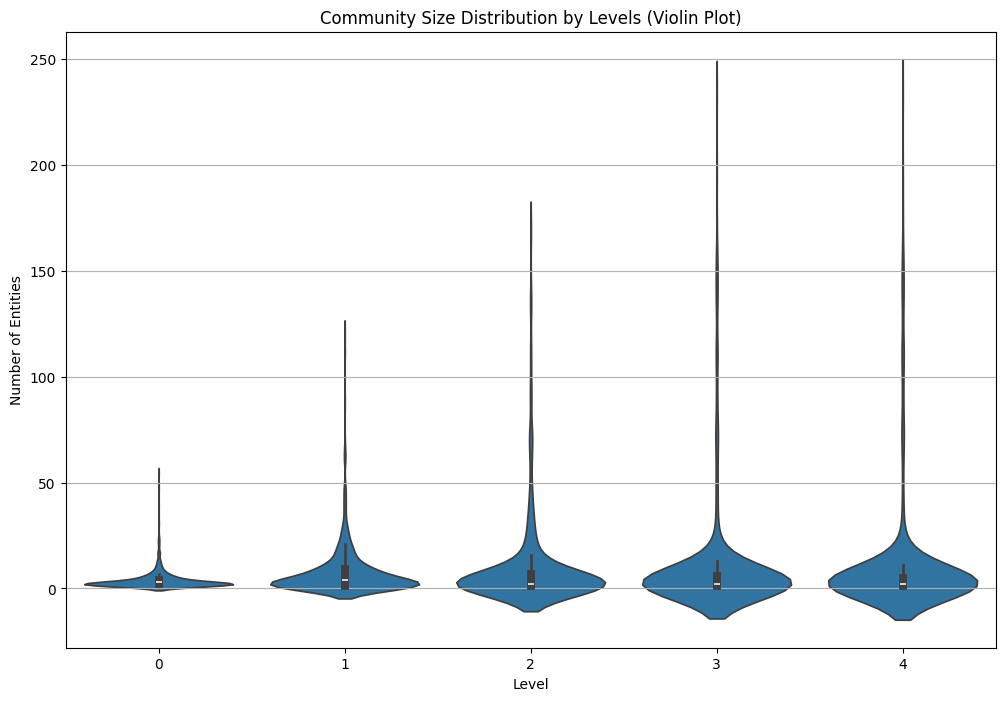

In [74]:
import numpy as np

community_size = graph.query("""
MATCH (c:__Community__)<-[:IN_COMMUNITY*]-(e:__Entity__)
WITH c, count(distinct e) AS entities
RETURN split(c.id, '-')[0] AS level, entities
""")
community_size_df = pd.DataFrame.from_records(community_size)
# Create the violin plot
plt.figure(figsize=(12, 8))
sns.violinplot(y='entities', x='level', data=community_size_df, scale='width')
plt.xlabel('Level')
plt.ylabel('Number of Entities')
plt.title('Community Size Distribution by Levels (Violin Plot)')
plt.grid(axis='y')
plt.show()

In [76]:
percentiles_data = []
for level in community_size_df['level'].unique():
    subset = community_size_df[community_size_df['level'] == level]['entities']
    percentiles = np.percentile(subset, [25, 50, 75])
    percentiles_data.append([level, percentiles[0], percentiles[1], percentiles[2]])

# Create a DataFrame with the percentiles
percentiles_df = pd.DataFrame(percentiles_data, columns=['Level', '25th Percentile', '50th Percentile', '75th Percentile'])
percentiles_df

,Level,25th Percentile,50th Percentile,75th Percentile
0,0,2.0,3.0,4.0
1,1,1.0,4.0,9.0
2,2,1.0,2.0,7.0
3,3,1.0,2.0,6.0
4,4,1.0,2.0,5.0


In [37]:
community_info = graph.query("""
MATCH (c:`__Community__`)<-[:IN_COMMUNITY*]-(e:__Entity__)
WITH c, collect(e ) AS nodes
WHERE size(nodes) > 1
CALL apoc.path.subgraphAll(nodes[0], {
	whitelistNodes:nodes
})
YIELD relationships
RETURN c.id AS communityId,
       [n in nodes | {id: n.id, description: n.description}] AS nodes,
       [r in relationships | {start: startNode(r).id, type: type(r), end: endNode(r).id, description: r.description}] AS rels
""")

In [38]:
community_info[5]

{'communityId': '0-5',
 'nodes': [{'id': 'Xpeng', 'description': 'Chinese electric car brand'},
  {'id': 'Beijing', 'description': 'Capital city of China'},
  {'id': 'Xpeng Stock', 'description': None},
  {'id': 'Self-Driving Technology', 'description': None},
  {'id': 'Hong Kong',
   'description': 'Potential future listing location for Didi.'},
  {'id': 'City Ngp', 'description': 'assisted driving software system'},
  {'id': 'Shanghai', 'description': 'City in China'},
  {'id': 'Guangzhou', 'description': 'City in China'},
  {'id': 'Shenzhen', 'description': 'City in China'},
  {'id': 'Xpeng Inc', 'description': None},
  {'id': 'Tesla Inc', 'description': None},
  {'id': 'Tsla Fsd', 'description': None},
  {'id': 'G6 Suv', 'description': None},
  {'id': 'March Of The Volunteers', 'description': None},
  {'id': 'Semiconductor Sector', 'description': None}],
 'rels': [{'start': 'Xpeng',
   'description': 'Released urban scenario driver-assist tech in March',
   'type': 'RELEASED',
   '

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

community_template = """Based on the provided triples that belong to the same graph community,
generate a natural language summary of the provided information:
{community_info}

Summary:"""  # noqa: E501

community_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Given an input triples, generate the information summary. No pre-amble.",
        ),
        ("human", community_template),
    ]
)

community_chain = community_prompt | llm | StrOutputParser()

In [ ]:
def process_community(community):
    stringify_info = "\n".join([f"{el['start']}-{el['type']}->{el['end']}" for el in community['rels']])
    summary = community_chain.invoke({'community_info': stringify_info})
    return {"community": community['communityId'], "summary": summary}

summaries = []
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(process_community, community): community for community in community_info}

    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing communities"):
        summaries.append(future.result())

Processing communities: 100%|██████████| 63/63 [00:10<00:00,  6.00it/s]


In [ ]:
# Store summaries
graph.query("""
UNWIND $data AS row
MERGE (c:Community {id:row.community})
SET c.summary = row.summary
""", params={"data": summaries})

[]

In [ ]:
# Do higher level communities...
graph.query("""
MATCH (e:`__Entity__`)
WITH e, '1-' + e.communities[0] AS communityId1, '2-' + e.communities[-1] AS communityId2
WITH distinct communityId1, communityId2
MATCH (c:Community {id: communityId1})
MERGE (c1:Community {id: communityId2})
MERGE (c)-[:PART_OF]->(c1)
""")

[]

In [ ]:
community_info = graph.query("""
MATCH (e:`__Entity__`)
WITH '2-' + e.communities[-1] AS communityId, collect(e) AS nodes
WHERE size(nodes) > 1
CALL apoc.path.subgraphAll(nodes[0], {
	whitelistNodes:nodes
})
YIELD relationships
RETURN communityId, [r in relationships | {start: startNode(r).id, type: type(r), end: endNode(r).id}] AS rels
""")

In [ ]:
summaries = []
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(process_community, community): community for community in community_info}

    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing communities"):
        summaries.append(future.result())

Processing communities: 100%|██████████| 41/41 [00:11<00:00,  3.54it/s]


In [ ]:
# Store summaries
graph.query("""
UNWIND $data AS row
MERGE (c:Community {id:row.community})
SET c.summary = row.summary
""", params={"data": summaries})

[]

In [ ]:
# Calculate embeddings
community_vector = Neo4jVector.from_existing_graph(
    OpenAIEmbeddings(),
    index_name="summariesIndex",
    node_label='Community',
    text_node_properties=['summary'],
    embedding_node_property='embedding'
)

In [ ]:
community_vector.similarity_search("What's the deal with EU and Huawei?", k=1)

[Document(page_content='\nsummary: The European Union considers Huawei Technologies Co. and Zte Corp. to be high-risk entities. Additionally, the European Union has imposed bans on Tiktok Inc., Zte Corp., and Huawei Technologies Co. Alberto Nardelli and Thomas Seal have both provided assistance to the European Union.')]

* repeat for larger community
* maybe connect community summaries to sth
* put a QA chain on top of